# (12) vH16 — ```mlp```, whitened

**Motivation**: host = ```any```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from analysis.chosen import *
from figures.analysis import *
from figures.imgs import plot_weights

device_idx = 1
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:1  ———  host: mach

## vH16

Intermediate beta: $(T, \beta) = (16, 6.0)$

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'jacob|lin')

seq_len = 16
cfg_vae['seq_len'] = seq_len

cfg_tr['kl_beta'] = 3/8 * seq_len

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.n_iters

poisson_vH16_t-16_z-[512]_<jacob|lin>
b200-ep300-lr(0.002)_beta(6:0x0.1)_temp(0.05:lin-0.5)_gr(200)_(2024_10_12,06:53)

154500

In [5]:
tr.train()

epoch # 300, avg loss: 69.216575: 100%|█████| 300/300 [2:16:16<00:00, 27.26s/it]


### Load

In [3]:
tr, meta = load_model(
    'poisson_vH16_t-16_z-[512]_<jacob|lin>',
    'b200-ep300-lr(0.002)_beta(6:0x0.1)_temp(0.05:lin-0.5)_gr(200)_(2024_10_12,06:53)',
    device=device,
)
meta['checkpoint']

300

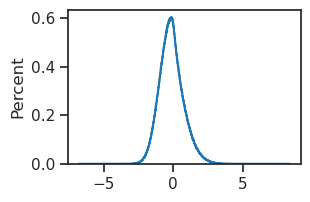

In [4]:
_ = histplot(tr.dl_vld.dataset.tensors[0].ravel(), stat='percent')

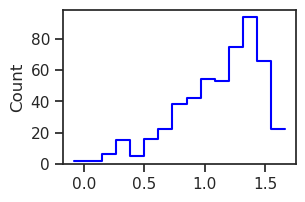

In [5]:
log_rate = tonp(tr.model.layer.log_rate.squeeze())
histplot(log_rate, color='b');

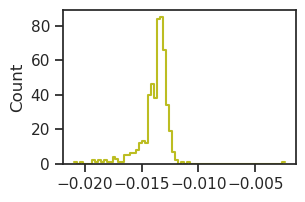

In [6]:
bias = tonp(tr.model.layer.bias.squeeze())
histplot(bias, color='C8');

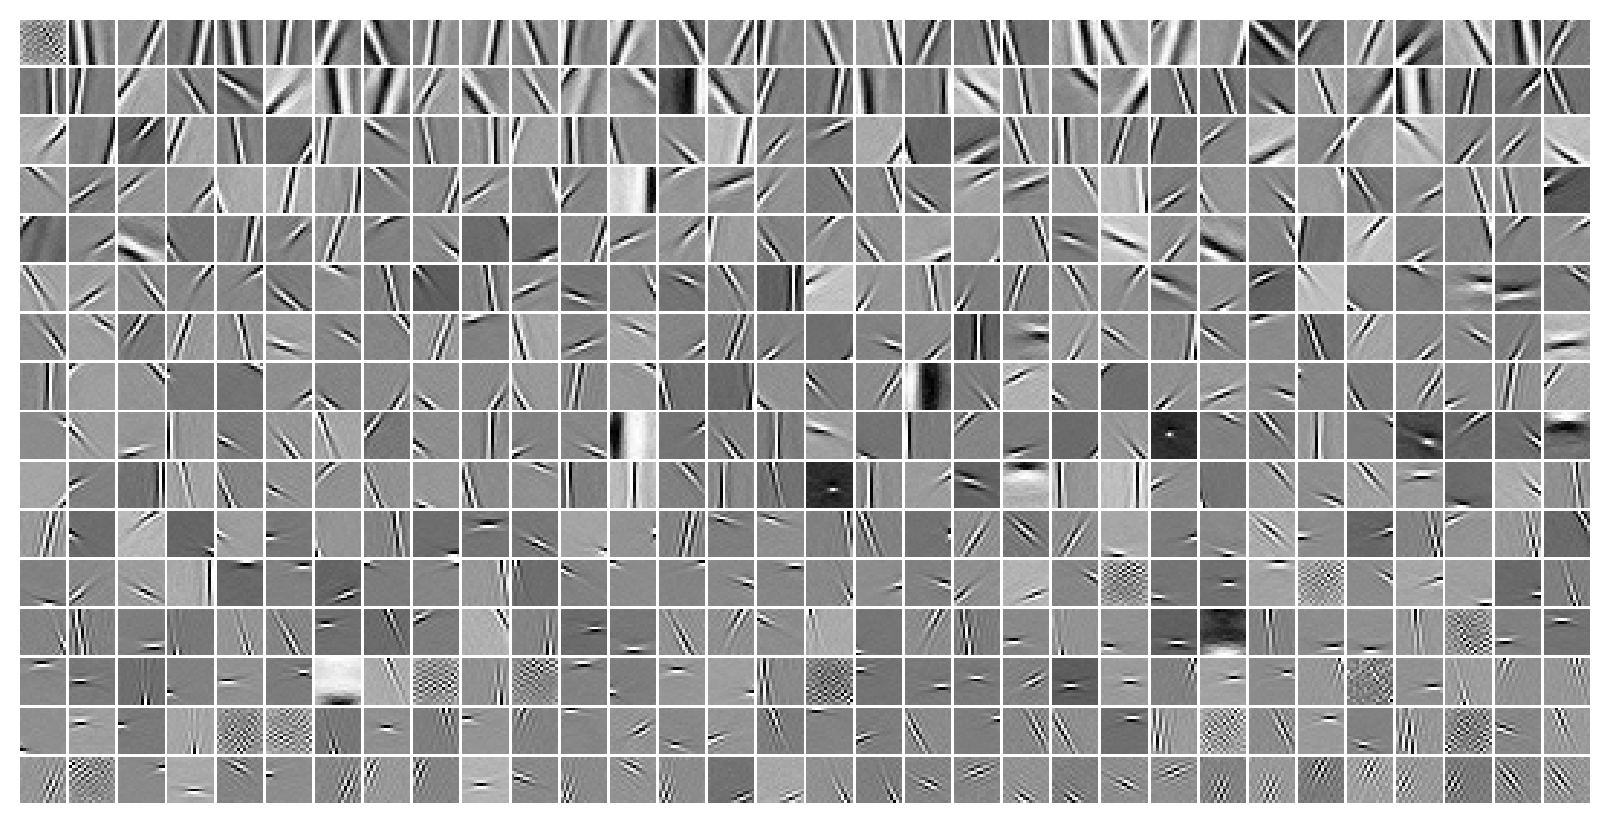

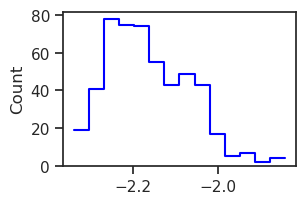

In [7]:
w = tr.model.layer.get_weight()
norms = tonp(torch.linalg.vector_norm(w, dim=1))

_ = tr.model.show(order=np.argsort(norms))

histplot(np.log(norms), label='log norm', color='b');

100%|█████████████████████████████████| 50/50 [20:52<00:00, 25.06s/it]


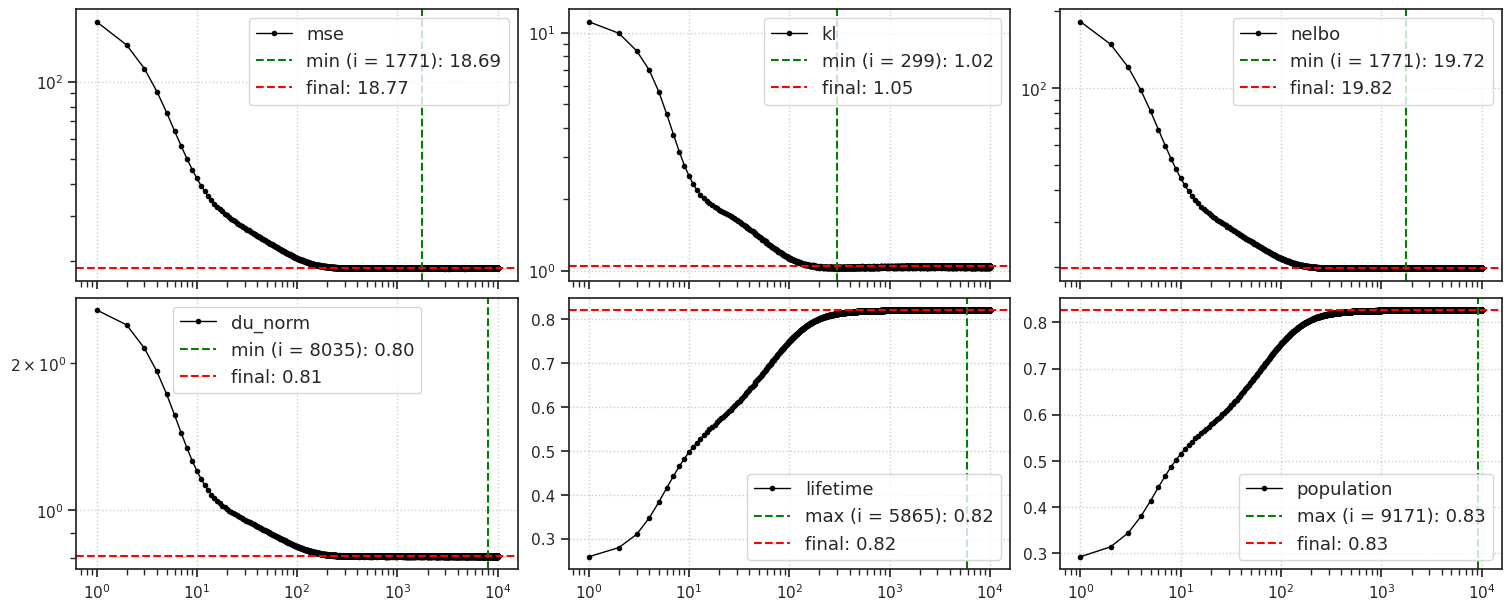

CPU times: user 27min 2s, sys: 3min 22s, total: 30min 24s
Wall time: 30min 23s


In [8]:
%%time

kws = dict(
    seq_total=10000,
    seq_batch_sz=1000,
    n_data_batches=50,
)
results = tr.analysis(**kws)

_ = plot_convergence(results, color='k')

In [8]:
x = next(iter(tr.dl_vld))[0]
x.shape

torch.Size([200, 1, 16, 16])

In [9]:
output = tr.model.xtract_ftr(
    x=x,
    seq=range(1000),
    return_extras=True,
).stack()

In [10]:
list(output)

['loss_kl', 'loss_recon', 'dist', 'ff', 'recon', 'state', 'samples']

In [11]:
output['ff'].shape

torch.Size([200, 1000, 512])

In [12]:
x2p = tonp(output['ff'].exp().mean(0))

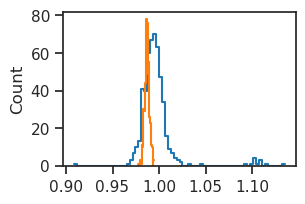

In [13]:
histplot(x2p[0])
histplot(x2p[-1]);

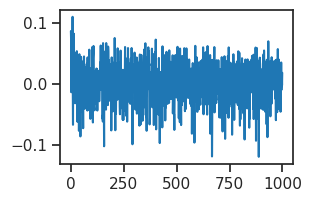

In [16]:
plot(output['ff'][123, :, 48]);